In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import zuko
from torch.optim import lr_scheduler

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep
from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc

import h5py
import numpy as np

from datetime import datetime

/home/opt/python/anaconda3.8_TF2.5/envs/torch_1.12.1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 模型搭建

In [2]:
LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER

# 训练

In [3]:
data_set_dir='/home/lichunyue/sty/train_p/'

In [5]:
#非采样器的
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。

aaaaa=[]

import gc
#tensor(-1.5224, device='cuda:0')
#for act in [nn.ReLU]:
#  for f in [0.0001]:
#    for weight_decay in [0]:
#       for liu in [zuko.flows.NSF]:
#        for transfomr in [12]:#特征提取的blocks
#         for num in [2048]:
#          for trans in [18]:#NF的残差块--画图的
#           for beishu in [1024]:
#

for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x



                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            model= ResNet(in_channels=4,classes=1).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            model.apply(weight_init)
            
            optimizer = optim.AdamW(model.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            loss = nn.BCEWithLogitsLoss()

            list_los=[]
            list_losvail=[]
        
            with tqdm(range(2000), unit='epoch') as tq:#epoch
                best_loss = np.inf#早停
                best_model_weights = None
                patience=30#10个周期不降就停
                i_all=0
                num=10000#总数
                num_v=2000
                datast=20#batch_size
                nnum=num//datast
                nnum_v=num_v//datast
                
                for epoch in tq:
                    optimizer.zero_grad()
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    all_x = torch.tensor(np.load(data_set_dir+f'train_x_{i_all}.npy'),dtype=torch.float32)
                    all_y = torch.tensor(np.load(data_set_dir+f'train_y_{i_all}.npy'),dtype=torch.float32)

                    all_x_vail = torch.tensor(np.load(data_set_dir+f'vail_x_{i_all}.npy'),dtype=torch.float32)
                    all_y_vail = torch.tensor(np.load(data_set_dir+f'vail_y_{i_all}.npy'),dtype=torch.float32)

                    i_all+=1
                    if i_all>=400:
                        i_all=0
                    

                    model.train()
                    losses = torch.stack([
                        step(loss(model(all_x[i].cuda()), all_y[i].cuda()))
                        for i in range(nnum) # 这样写是遍历全部元素，实例那样是因为他是采样器
                    ])
                    
                    del all_x,all_y
                    
                    model.eval()
                    with torch.no_grad():
                        val_losses = torch.stack([
                            loss(model(all_x_vail[i].cuda()), all_y_vail[i].cuda())
                            for i in range(nnum_v)
                        ])
                    
                    scheduler.step()#学习率衰减
                    
                    tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

                    del all_x_vail,all_y_vail
                    
                    los=losses.mean().item()#类型不对，所以换名字
                    losval=val_losses.mean().item()#类型不对，所以换名字
                    
                    list_los.append(los)#话损失函数图
                    list_losvail.append(losval)#话损失函数图

                    # 储存监视
                    data1 = list_los
                    data2 = list_losvail
                    last= now
                    now = datetime.now()
                    # 打开一个文件用于写入
                    file = open('resnet_p.txt', 'w')
                    file.write('last_last:'+str(last) + '\n')
                    file.write('___last__:'+str(now) + '\n')
                    
                    # 将每个元素写入文件中
                    for item1, item2 in zip(data1, data2):
                        file.write(str(item1) + ' ' + str(item2) + '\n')
                    
                    # 关闭文件
                    file.close()
                    
                    del losses,data1,data2
                    
                    if losval < best_loss:
                        best_loss = losval
                        epochs_without_improvement = 0
                        best_model_weights = model.state_dict()
                    else:
                        epochs_without_improvement += 1

                    # 如果验证集上的损失连续patience个epoch没有提高，则停止训练
                    if epochs_without_improvement == patience:
                        model.load_state_dict(best_model_weights)
                        print('Early stopping at epoch {}...'.format(epoch-patience+1))
                        break
            aaaaa.append('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-patience],len(list_los)-patience))
            print('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-patience],len(list_los)-patience))

  6%|▌         | 120/2000 [6:37:05<103:41:13, 198.55s/epoch, loss=0.134, val_loss=0.125] 

Early stopping at epoch 91...
act<class 'torch.nn.modules.activation.ReLU'>学习率0.0001,正则化0,,参数数目10000,参数层数7,流层9,中间层2048,最佳损失0.14027142524719238,训练周期91


In [6]:
torch.save(model, f'./net_ann_2/NPE_mid_t_lens_yyy_all.pth')

# 测试

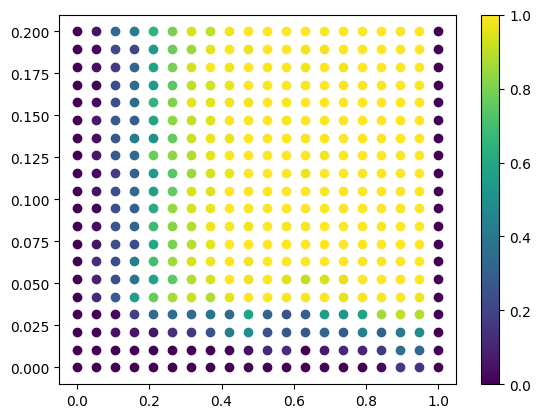

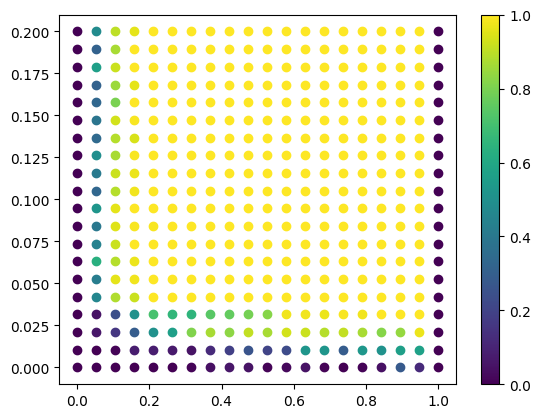

In [20]:
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_PM_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail=torch.tensor(all_x_vail_data,dtype=torch.float32)
            y_pre_all=[]
            for i in range(100):
                model.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)



    plt.colorbar()
    plt.show()

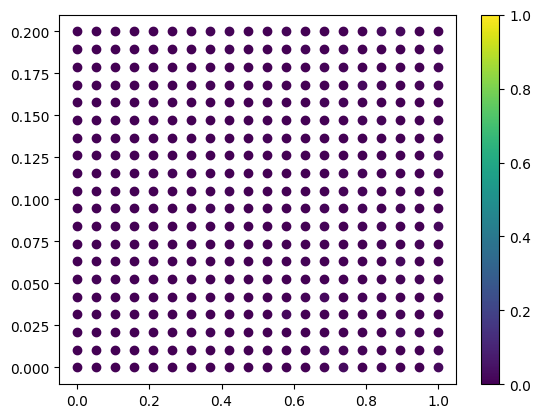

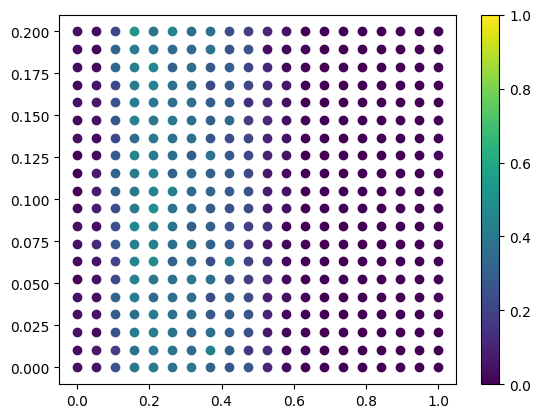

In [21]:
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{1}_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail=torch.tensor(all_x_vail_data,dtype=torch.float32)
            y_pre_all=[]
            for i in range(100):
                model.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


                        
    plt.colorbar()
    plt.show()

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像


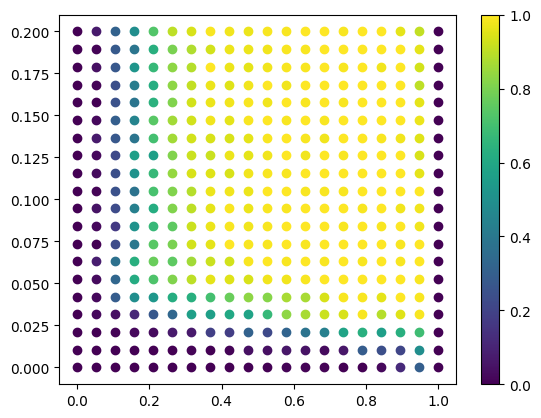

此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像
此条件不可能两个像


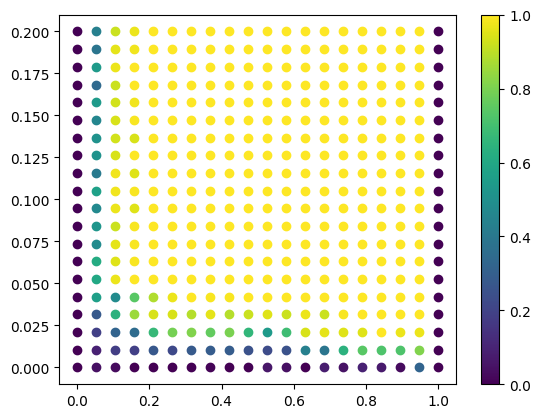

In [24]:
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            try:
                all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{2}_data_{I_tt}_{dtt}_{SNRRR}.npy')
                all_x_vail=torch.tensor(all_x_vail_data,dtype=torch.float32)
            except:
                print('此条件不可能两个像')
            y_pre_all=[]
            for i in range(100):
                model.eval()
                with torch.no_grad():
                    y_pre = torch.sigmoid(model(all_x_vail[i].cuda()[np.newaxis, :]))
                y_pre_all.append(float(y_pre))

            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


                        
    plt.colorbar()
    plt.show()